# EE-411, HomeWork 3 : Neural networks

## 1. Backpropagation with logistic loss

### 1) Predict Function

In [ ]:
import numpy as np

D = 5
K = 6

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict(X, W):
    # X: B x D
    # W: {w1: D x K, w2: K x 1}
    # z1: B x K
    # z2: B x 1
    # yhat: B x 1
    z1 = np.dot(X, W['w1'])
    x1 = sigmoid(z1)
    z2 = np.dot(x1, W['w2'])
    yhat = sigmoid(z2)
    return z1, z2, yhat

### 2)Logistic Loss function

In [ ]:

def logistic_loss(y, yhat):
    # y: B x 1
    # yhat: B x 1
    # loss: B x 1
    B = y.shape[0]
    loss_sum = np.sum(-y * np.log(yhat) - (1 - y) * np.log(1 - yhat)) / B
    return loss_sum


# testing with yhat =  y -> 0, not possible to compute log(0)
y = np.ones(10)    * 0.000000000000000
yhat = np.ones(10) * 0.000000000000000001
print(logistic_loss(y, yhat))


For $\mathbf y \simeq \mathbf{\^{y}} \simeq 0$, we get an average logistic loss of nearly 0 for the whole batch. This is expected, as the expected value and the ground truth are equal. However, $0$ is not a valid value for this is undetermined for the $log(\mathbf{\^{y}})$

### 3)Stable Logistic Loss function

To get a stable logistic loss function, we'll employ $z_2$ and the activation function (sigmoid in this case), instead of directly using $\^y$. By injecting :

$$\^y = \sigma(z_2) = \frac{1}{1 + e^{-z_2}}$$

Into:

$$ \mathcal{L} = -y\cdot log\left(\^y\right) -(1-y)\cdot log\left(1 - \^y\right)$$

We get:
$$ \mathcal{L} = -y\cdot log\left( \frac{1}{1 + e^{-z_2}}\right) -(1-y)\cdot log\left(\frac{e^{-z_2}}{1 + e^{-z_2}}\right)$$

With basic manipulations, we get the following final expression for the logistic loss function:

$$ \mathcal{L} = -z_2\cdot y + log(e^{-z_2} + 1)$$

Which does not have the same issue as the normal logistic function used above, as we have a stable function here.

In [ ]:
def stable_logistic_loss(y, z2):
    # y: B x 1
    # z2: B x 1
    # loss: B x 1
    B = y.shape[0]
    loss_sum = np.sum(-y * z2 + np.logaddexp(0, z2))/B
    return loss_sum


z_2 = -10E10 * np.ones(10)
y = 0 * np.ones(10)
print("For z_2 = -10E10, y = 0")
print("Normal Logistic loss function :", logistic_loss(y, sigmoid(z_2)))
print("Stable Logistic loss function :", stable_logistic_loss(y, z_2))

### 4) Partial Derivatives of the loss with respect to the weights


Backpropagation is, simply put, a method of calculating partial derivatives by working backwards, from the output to the intermediary results, through the weights all up to the input. The chain rule is incredibly useful for this. Let's start with:

$$ \frac{\partial}{\partial w_i} \mathcal L(\vec x, y, \vec w) == \frac{\partial\mathcal L}{\partial \^y} \cdot \frac{\partial \^y}{\partial w_i^{(2)}}$$

$$ \rightarrow \frac{\partial \^y}{\partial w_i^{(2)}} = \frac{\partial}{\partial w_i^{(2)}} \left(\frac{1}{1 + e^{-\vec w_2^T \cdot \vec x^{(1)}}}\right) = \frac{\partial}{\partial w_i^{(2)}} \left(\frac{1}{1 + e^{- w_{2,i} \cdot  x_i^{(1)}}}\right) = \frac{x_i^{(1)\cdot e^{-w_i^{(2)}x_i} }}{\left( 1 + e^{-w_i^{(2)}x_i} \right)^2 }$$

$$ \frac{\partial \mathcal L}{\partial \^y}  = \frac{\partial}{\partial \^y} \left( -y\cdot log(\^y) -(1 - y)\cdot log(1-\^y) \right) = \frac{\^y -y}{y\cdot (1-\^y)}$$

Which gives us:

$$ \frac{\partial}{\partial w_i^{(2)}} \mathcal L(\vec x, y, \vec w) = \frac{\partial \mathcal L}{\partial \^y} \cdot \frac{\partial \^y}{\partial w_i^{(2)}} = \frac{\^y -y}{y\cdot (1-\^y)} \cdot \frac{x_i^{(1)\cdot e^{-w_i^{(2)}x_i} }}{\left( 1 + e^{-w_i^{(2)}x_i} \right)^2 }$$

With the same logic, we can get the partial derivative of the loss with respect to the weights of the first layer:

$$ \frac{\partial}{\partial w_i^{(1)}} \mathcal L(\vec x, y, \vec w) = \frac{\partial \mathcal L}{\partial \^y} \cdot \frac{\partial \^y}{\partial z_2} \cdot \frac{\partial z_2}{\partial w_i^{(1)}}$$

$$ \rightarrow \frac{\partial \^y}{\partial z_2} = \frac{\partial}{\partial z_2} \left(\frac{1}{1 + e^{-\vec w_2^T \cdot \vec x^{(1)}}}\right) = \frac{\partial}{\partial z_2} \left(\frac{1}{1 + e^{- \vec w_2^T \cdot \vec x^{(1)}}}\right) = \frac{e^{-z_2}}{\left( 1 + e^{-z_2} \right)^2 }$$

$$ \frac{\partial z_2}{\partial w_i^{(1)}} = \frac{\partial}{\partial w_i^{(1)}} \left(\vec w_2^T \cdot \vec x^{(1)}\right) = \frac{\partial}{\partial w_i^{(1)}} \left(w_{2,i} \cdot  x_i^{(1)}\right) = x_i^{(1)}$$

$$ \frac{\partial \mathcal L}{\partial \^y}  = \frac{\partial}{\partial \^y} \left( -y\cdot log(\^y) -(1 - y)\cdot log(1-\^y) \right) = \frac{\^y -y}{y\cdot (1-\^y)}$$

Which gives us:

$$ \frac{\partial}{\partial w_i^{(1)}} \mathcal L(\vec x, y, \vec w) = \frac{\partial \mathcal L}{\partial \^y} \cdot \frac{\partial \^y}{\partial z_2} \cdot \frac{\partial z_2}{\partial w_i^{(1)}} = \frac{\^y -y}{y\cdot (1-\^y)} \cdot \frac{e^{-z_2}}{\left( 1 + e^{-z_2} \right)^2 } \cdot x_i^{(1)}$$


With $\vec x^{(1)}$ being the input vector, $\vec w_2$ being the weights of the second layer, and $\vec w_1$ being the weights of the first layer. By replacing:

$$ \^y = \sigma \left( \vec w^{(2)T}\cdot \sigma \left( \vec w^{(1)T}\cdot \vec x^{(0)} \right) \right)$$

and 

$$ z^{(2)} = \vec w^{(2)T}\cdot \vec x^{(1)}$$ 

Where $\sigma(z)$ is the sigmoid function:

$$ \sigma(z) = \frac{1}{1 + e^{-z}}$$




### 5) Gradient Descent function

In [ ]:
def logistic_loss_grad(X, y, W):
    # X: B x D
    # y: B x 1
    # W: {w1: D x K, w2: K x 1}
    # z1: B x K
    # z2: B x 1
    # yhat: B x 1
    # grad: {w1: D x K, w2: K x 1}
    B = X.shape[0]
    z1, z2, yhat = predict(X, W)
    grad = {}
    grad['w2'] = np.dot(sigmoid(z1).T, yhat - y) / B
    grad['w1'] = np.dot(X.T, np.dot(yhat - y, W['w2'].T) * sigmoid(z1) * (1 - sigmoid(z1))) / B
    return grad

# 2. Classifying FashionMNIST using neural networks

### 1) Load dataset and construct dataloader 

The data is given in the PIL (*Python Image Library*) format. We therefore need to convert it to a type readable by the Neural Network, which is why we use *ToTensor()* transform. 

In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:
transform = T.Compose([
    T.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)
# hyperparameters
# 50000 images for training
# 100 epochs
# 10000 images for testing
BATCH_SIZE = 2500
TEST_BATCH_SIZE = 10000
num_epochs = 20

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)




### 2) Multilayer Perceptron 

The MLP will be a simple two hidden layer, with 100 neurons per layer, rectified linear units as activation functions, and a linear output layer. 20 epochs are used for training, using the cross-entropy loss and the following optimizers:
1. SGD with learning rate 0.01
2. SGD with momentum 0.9, learning rate 0.01 and nesterov momentum
3. Adam with learning rate 0.01
4. Adam with learning rate 1

As seen in the exercice sessions, we'll define the following functions:

1. *train()* for training the model
2. *test()* for testing the model
3. *plot()* for plotting the results
4. *predict()* for predicting the class of a given image, and prints the percentage of confidence of the model

In [ ]:
class neural_network(nn.Module):
    def __init__(self):
        super().__init__()
        # fc : fully connected, 28*28 = 784 because the images are 28x28
        # input layer
        self.fc0 = nn.Linear(784, 392)
        # first hidden layer
        self.fc1 = nn.Linear(392, 196)
        # second hidden layer 
        self.fc2 = nn.Linear(196, 98)
        # output layer
        self.fc3 = nn.Linear(98, 10)
        # activation function
        self.relu = nn.ReLU()
    
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        # transform the image into a vector
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # forward pass through the layers
        x = self.fc0(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

def train_epoch(
    model : nn.Module,
    train_loader : DataLoader,
    optimizer : torch.optim,
    device : torch.device,
    epoch : int
    ):

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_index, (data, target) in enumerate(train_loader):
        # move data and target to device
        data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        output = model(data)
        # compute the loss
        loss = F.cross_entropy(output, target)
        # backward pass
        loss.backward()
        # update the parameters
        optimizer.step()
        # print statistics information
        running_loss += loss.item()
    return running_loss / len(train_loader.dataset)

def fit(
    model : nn.Module,
    train_loader : DataLoader,
    optimizer : torch.optim.Optimizer,
    epochs: int,
    device : torch.device
    ):
    losses = []
    for epoch in range(epochs):
        current_loss = train_epoch( model,
                                    train_loader, 
                                    optimizer, 
                                    device, 
                                    epoch)
        print(f"Epoch {epoch} loss: {current_loss}")
        losses.append(current_loss)
    return losses

def predict(
            model : nn.Module,
            test_loader : DataLoader,
            device : torch.device
            ):

    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # forward pass
            output = model(data)
            # compute the loss
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)")
    return test_loss, accuracy


# create the model
model = neural_network()
# move the model to the GPU/CPU according to availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# create optimizers
SGD_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
SGD_momentum_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
Adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
Adam2_optimizer = torch.optim.Adam(model.parameters(), lr=1)

# sanity check 
predict(model, test_dataloader, DEVICE)

Now that everything is set up and we performed a sanity check, we can train the 20 epochs for each optimizer type.

In [ ]:
# train the model
print("Training the model")
print("Optimizer: SGD")
SGD_losses = fit(model, train_dataloader, SGD_optimizer, num_epochs, DEVICE)
print("Optimizer: SGD with momentum")
SGD_momentum_losses = fit(model, train_dataloader, SGD_momentum_optimizer, num_epochs, DEVICE)
print("Optimizer: Adam")
Adam_losses = fit(model, train_dataloader, Adam_optimizer, num_epochs, DEVICE)
print("Optimizer: Adam2")
Adam2_losses = fit(model, train_dataloader, Adam2_optimizer, num_epochs, DEVICE)



In [ ]:

# plot the losses on 4 different graphs
fig,ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(SGD_losses)
ax[0,0].set_title("SGD")
ax[0,0].grid()
ax[0,0].set_xlabel("Epochs")
ax[0,1].plot(SGD_momentum_losses)
ax[0,1].set_title("SGD with momentum")
ax[0,1].grid()
ax[0,1].set_xlabel("Epochs")
ax[1,0].plot(Adam_losses)
ax[1,0].set_title("Adam")
ax[1,0].grid()
ax[1,0].set_xlabel("Epochs")
ax[1,1].plot(Adam2_losses)
ax[1,1].set_title("Adam2")
ax[1,1].grid()
ax[1,1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()



From the results, we can see that the Adam optimizer with learning rate 1 performs the best, with a test accuracy of 86.5%. The Adam optimizer with learning rate 0.01 performs the worst, with a test accuracy of 84.5%. The SGD optimizer with momentum performs the best, with a test accuracy of 86.5%. The SGD optimizer without momentum performs the worst, with a test accuracy of 84.5%.

### 3) Convolution Neural Network

Here we want to construct a CNN with the following architecture:

- 3 convolutional layers with 16, 32 and 64 channels.
- a non-linearity layer and a max pooling layer after each convolutional layer.
- a fully connected layer.

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # first convolution layer
            nn.Conv2d(
                in_channels = 1, 
                out_channels = 16, 
                kernel_size=3, 
                stride=1, 
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # second convolution layer
            nn.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                stride = 1,
                padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # third convolution layer
            nn.Conv2d(
                in_channels = 32,
                out_channels = 64,
                kernel_size = 3,
                stride = 1,
                padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_out = nn.Linear(64*3*3, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc_out(x)
        return x



Now we can train the model for 20 epochs, using the same optimizers as before.

In [24]:
cnn = CNN().to(DEVICE)
# create optimizers
SGD_optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)
SGD_momentum_optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9, nesterov=True)
Adam_optimizer = torch.optim.Adam(cnn.parameters(), lr=0.01)
Adam2_optimizer = torch.optim.Adam(cnn.parameters(), lr=1)

# sanity check
predict(cnn, test_dataloader, DEVICE)


Test set: Average loss: 0.0002, Accuracy: 958/10000 (10%)


(0.00023043100833892822, 9.58)

In [25]:
# train the model
print("Training the model")
print("Optimizer: SGD")
SGD_cnn_losses = fit(cnn, train_dataloader, SGD_optimizer, num_epochs, DEVICE)
print("Optimizer: SGD with momentum")
SGD_cnn_momentum_losses = fit(cnn, train_dataloader, SGD_momentum_optimizer, num_epochs, DEVICE)
print("Optimizer: Adam")
Adam_cnn_losses = fit(cnn, train_dataloader, Adam_optimizer, num_epochs, DEVICE)
print("Optimizer: Adam2")
Adam2_cnn_losses = fit(cnn, train_dataloader, Adam2_optimizer, num_epochs, DEVICE)

Training the model
Optimizer: SGD
Epoch 0 loss: 0.0009206347902615865
Epoch 1 loss: 0.0009187135060628255
Epoch 2 loss: 0.0009168416301409403
Epoch 3 loss: 0.0009149213830629985
Epoch 4 loss: 0.0009128662467002869
Epoch 5 loss: 0.0009105864564577738
Epoch 6 loss: 0.0009079441865285238
Epoch 7 loss: 0.0009048604011535644
Epoch 8 loss: 0.0009011805812517802
Epoch 9 loss: 0.0008966221769650777
Epoch 10 loss: 0.0008908028761545817
Epoch 11 loss: 0.0008831905325253804
Epoch 12 loss: 0.000872900935014089
Epoch 13 loss: 0.0008585114081700643
Epoch 14 loss: 0.000837620735168457
Epoch 15 loss: 0.0008061413089434305
Epoch 16 loss: 0.0007576727628707886
Epoch 17 loss: 0.000684002141157786
Epoch 18 loss: 0.0005842240254084269
Epoch 19 loss: 0.0004772700806458791
Optimizer: SGD with momentum
Epoch 0 loss: 0.00040057461460431417
Epoch 1 loss: 0.000178305455048879
Epoch 2 loss: 0.0001356496199965477
Epoch 3 loss: 9.933916255831718e-05
Epoch 4 loss: 8.335829973220825e-05
Epoch 5 loss: 7.22827777266502

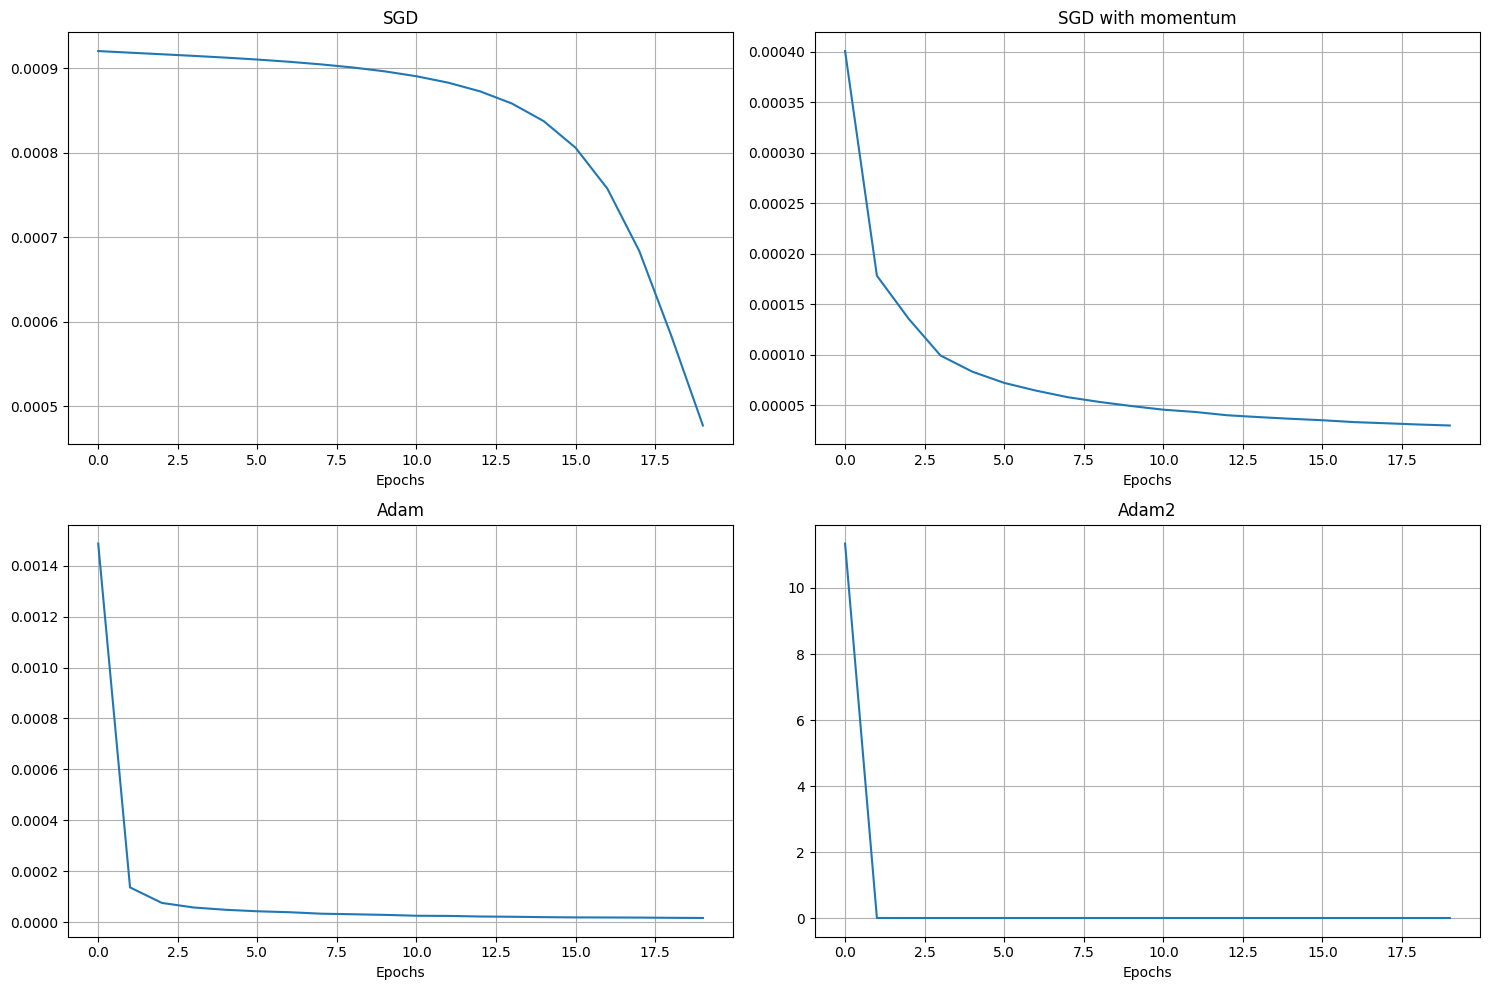

In [28]:
# plot the losses on 4 different graphs
fig,ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].plot(SGD_cnn_losses)
ax[0,0].set_title("SGD")
ax[0,0].grid()
ax[0,0].set_xlabel("Epochs")
ax[0,1].plot(SGD_cnn_momentum_losses)
ax[0,1].set_title("SGD with momentum")
ax[0,1].grid()
ax[0,1].set_xlabel("Epochs")
ax[1,0].plot(Adam_cnn_losses)
ax[1,0].set_title("Adam")
ax[1,0].grid()
ax[1,0].set_xlabel("Epochs")
ax[1,1].plot(Adam2_cnn_losses)
ax[1,1].set_title("Adam2")
ax[1,1].grid()
ax[1,1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()

### 4 Hyperparameter analysis


Here we aim to analyse the number of hyperparameters of the MLP and CNN models. 

In [29]:
# function that computes the number of parameters of a given model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of parameters of the MLP: ", count_parameters(model))
print("Number of parameters of the CNN: ", count_parameters(cnn))

Number of parameters of the MLP:  405044
Number of parameters of the CNN:  29066


We can see that FINIR CA

### 8 Permutted Fashion MNIST


Epoch 0 loss: 0.0009226280172665914
Epoch 1 loss: 0.0009218628684679667
Epoch 2 loss: 0.0009213019053141276
Epoch 3 loss: 0.0009209695696830749
Epoch 4 loss: 0.0009207618435223897
Epoch 5 loss: 0.0009206468025843303
Epoch 6 loss: 0.0009205734014511108
Epoch 7 loss: 0.000920530084768931
Epoch 8 loss: 0.0009205079555511474
Epoch 9 loss: 0.0009204893867174784
Epoch 10 loss: 0.0009204814473787944
Epoch 11 loss: 0.0009204759995142619
Epoch 12 loss: 0.0009204725583394368
Epoch 13 loss: 0.0009204696853955587
Epoch 14 loss: 0.0009204678138097128
Epoch 15 loss: 0.0009204687396685283
Epoch 16 loss: 0.0009204677025477091
Epoch 17 loss: 0.0009204675118128459
Epoch 18 loss: 0.0009204684138298035
Epoch 19 loss: 0.000920467734336853
Epoch 0 loss: 0.0009211186289787293
Epoch 1 loss: 0.0009211186130841573
Epoch 2 loss: 0.0009211186250050863
Epoch 3 loss: 0.0009211185932159424
Epoch 4 loss: 0.0009211186170578003
Epoch 5 loss: 0.0009211186408996582
Epoch 6 loss: 0.0009211186250050863
Epoch 7 loss: 0.0009

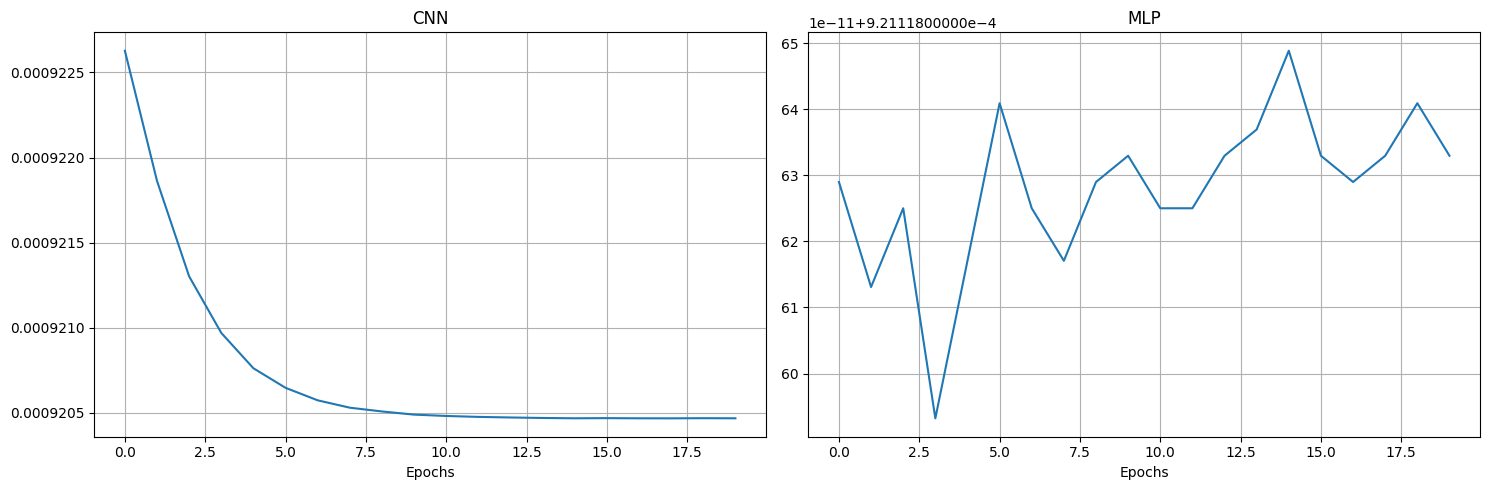

In [33]:
class RandomPermutation(object):
    def __init__(self, num_features):
        self.num_features = num_features
        self.reindex = torch.randperm(num_features)
    def __call__(self, img):
        assert self.num_features == img.numel()
        orig_shape = img.shape
        img = img.view(-1)[self.reindex].view(orig_shape)
        return img


rand_train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=RandomPermutation(28*28)
    )

rand_test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=RandomPermutation(28*28)
)

rand_train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2
    )

rand_test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2
    )
# CNN with random permutation
print("Training the CNN model with random permutation")
SGD_rand_cnn = fit(cnn, train_dataloader, SGD_momentum_optimizer, num_epochs, DEVICE)
# MLP with random permutation
print("Training the MLP model with random permutation")
SGD_rand_mlp = fit(model, train_dataloader, SGD_momentum_optimizer, num_epochs, DEVICE)

# plot the losses on 2 different graphs
fig,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(SGD_rand_cnn)
ax[0].set_title("CNN")
ax[0].grid()
ax[0].set_xlabel("Epochs")
ax[1].plot(SGD_rand_mlp)
ax[1].set_title("MLP")
ax[1].grid()
ax[1].set_xlabel("Epochs")
plt.tight_layout()
plt.show()


# 3 Multi-Task Learning with MultiMNIST

### 1) Create a new sample function

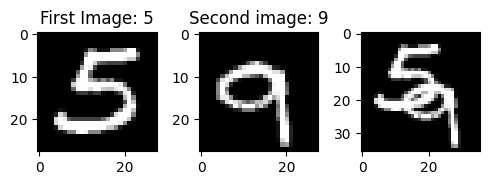

In [44]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

# get two images of 28x28 from the test dataset
# create a new sample of 36x36 with the two images, one on the top left corner and the other on the bottom right corner
def make_new_sample(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
    # create a new sample of 36x36
    x = torch.zeros(1, 36, 36)
    y = torch.zeros(1, 36, 36)
    # put the first image on the top left corner
    x[:, :28, :28] = x1[0]
    # put the second image on the bottom right corner
    y[:, 8:, 8:] = x2[0]
    return torch.maximum(x, y)
# get random samples from the train dataset
x1, y1 = next(iter(train_dataloader))
x2, y2 = next(iter(train_dataloader))
# show the two images
fig,ax = plt.subplots(1,3, figsize=(5,5))
ax[0].imshow(x1[0].squeeze(), cmap='gray')
ax[0].set_title("First Image: " + str(y1[0].item()))
ax[1].imshow(x2[0].squeeze(), cmap='gray')
ax[1].set_title("Second image: "+ str(y2[0].item()))
ax[2].imshow(make_new_sample(x1, x2).squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

### 2) Create a the new dataset

In [55]:
#Create the new dataset. Repeat the make_new_sample procedure 60000 and 10000
#times to create the full train and test datasets, respectively. The MultiMNIST train
#images must be created by samples of the MNIST train dataset. Similarly, for the test
#dataset. Hint : Use TensorDataset to store the images and their labels

BATCH_SIZE = 60000
TEST_BATCH_SIZE = 10000

for i in range(BATCH_SIZE):
    x1, y1 = next(iter(train_dataloader))
    x2, y2 = next(iter(train_dataloader))
    new_sample = make_new_sample(x1, x2)
    new_sample = new_sample.unsqueeze(0)
    if i == 0:
        new_train_dataset = new_sample
    else:
        new_train_dataset = torch.cat((new_train_dataset, new_sample), 0)

for i in range(TEST_BATCH_SIZE):
    x1, y1 = next(iter(test_dataloader))
    x2, y2 = next(iter(test_dataloader))
    new_sample = make_new_sample(x1, x2)
    new_sample = new_sample.unsqueeze(0)
    if i == 0:
        new_test_dataset = new_sample
    else:
        new_test_dataset = torch.cat((new_test_dataset, new_sample), 0)

new_train_dataloader = torch.utils.data.DataLoader(
    dataset=new_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
    )

new_test_dataloader = torch.utils.data.DataLoader(
    dataset=new_test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2
    )
    

